### **Imports Made**:
- Numpy for general purpose tasks (ex: file loads, matrix operations and arrangements, etc)
- TensorFlow for the entire CNN structure and implementation, as well as a multitude of additional general purpose functions regarding machine learning
- sklearn.model_selection for the train test split function that allows our data split
- sklearn.linear_metrics for more precise accuracy indicators, and confusion matrix representation
- imlearn.over_sampling for the SMOTE data augmentation function

The key metric to be evaluated will be Balanced Accuracy, just as stated in the project report, but f1 also provides useful insight.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, balanced_accuracy_score
from imblearn.over_sampling import SMOTE

### **Data Extraction**:

Input files are loaded into variables *x*, *y* and *x_project*, this last one being from the *x_test* file. Commented below is a subset of code that performs outlier removal of two points who in a previous analysis were thought to be harmful for our model. But later these points did appear to have a degree of importance, especially due to them being similar to a couple of points in the testing samples. What is not commented, is the removal of four features from x_train and x_test, these same features from analysis through lasso revealed to be a little bit harmful to the SSE of our model. Thus, removing said dimensions improves our accuracy while still keeping our model structured and secure.

There is a 85.78852688386968 proportion between classes
There is a 14.211473116130321 proportion between classes


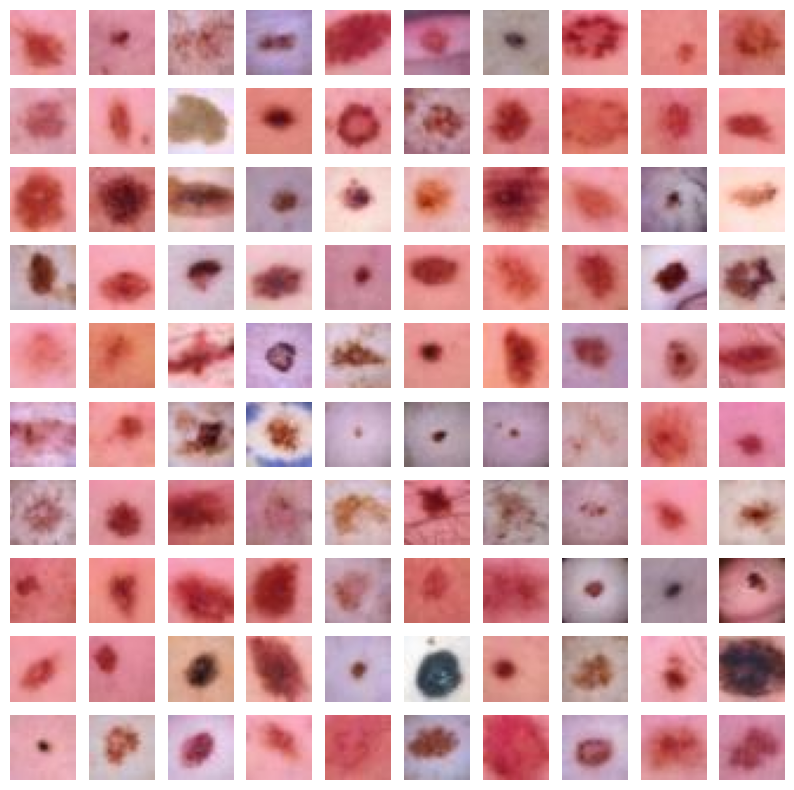

In [2]:

augmented_class2 = []

# Load data
x = np.load("Xtrain_Classification1.npy")
y = np.load("ytrain_Classification1.npy")
x_test = np.load("Xtest_Classification1.npy")

# 255 is the biggest number any value of x can take

# x = np.reshape(x,(len(x),28,28,3))

x = (x).astype('float32')/255.0

X_train, X_val, y_train, y_val = train_test_split(x, y, test_size = 0.2)

y_val_tl = tf.keras.utils.to_categorical(y_val)

class1 = X_train[y_train == 0]
class2 = X_train[y_train == 1]

n_class1 = len([0 for i in range(y_train.shape[0]) if y_train[i] == 0])
n_class2 = len([0 for i in range(y_train.shape[0]) if y_train[i] == 1])

print(f'There is a {(n_class1/(n_class1 + n_class2)) * 100} proportion between classes')
print(f'There is a {(n_class2/(n_class1 + n_class2)) * 100} proportion between classes')

smote = SMOTE()
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

y_train_tl = tf.keras.utils.to_categorical(y_train_balanced)

X_train_balanced = np.reshape(X_train_balanced,(len(X_train_balanced),28,28,3))
X_val = np.reshape(X_val,(len(X_val),28,28,3))


plt.figure(figsize=(10, 10))
for i in range(100):
    ax = plt.subplot(10, 10, i + 1)
    plt.imshow(X_train_balanced[i])
    plt.axis("off")

'''
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.5),
])

for i in range(n_class1 - n_class2):
    random_index = np.random.randint(0, n_class2)
    augmented_image = data_augmentation(tf.expand_dims(class2[random_index], 0))
    augmented_class2.append(augmented_image)

augmented_class2 = np.vstack(augmented_class2)

X_train_balanced = np.vstack([X_train, augmented_class2])
y_train_balanced = np.concatenate([y_train, np.ones(n_class1 - n_class2)])

'''

y_train_balanced = tf.keras.utils.to_categorical(y_train_balanced,2)
y_val = tf.keras.utils.to_categorical(y_val,2)




In [3]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

X_train_tl = tf.image.resize(X_train_balanced, (150,150))



In [4]:

X_val_tl = tf.image.resize(X_val, (150,150))

base_model = InceptionV3(input_shape = (150, 150, 3), include_top = False, weights = 'imagenet')


87910968/87910968 [==============================] - 13s 0us/step


In [5]:

for layer in base_model.layers:
    layer.trainable = False

x = tf.keras.layers.Flatten()(base_model.output)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)

# Add a final sigmoid layer with 1 node for classification output
x = tf.keras.layers.Dense(2, activation='softmax')(x)

model = tf.keras.models.Model(base_model.input, x)

adam = tf.keras.optimizers.Adam(learning_rate = 0.001)



In [6]:


model.compile(optimizer = adam, loss = tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics = ['acc'])


In [7]:


inc_history = model.fit(x = X_train_tl, y = y_train_balanced, validation_data = (X_val_tl,y_val), epochs = 10, batch_size = 32)

Epoch 1/10


c:\Users\fjina\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\backend.py:5805: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


269/269 [==============================] - 169s 614ms/step - loss: 0.8665 - acc: 0.7558 - val_loss: 0.4567 - val_acc: 0.7650
Epoch 2/10
269/269 [==============================] - ETA: 0s - loss: 0.3518 - acc: 0.8432